## Analysis notebook

### Imports

In [24]:
from bokeh.plotting import output_file, save
import json
import os
import pickle
from locpix_points.data_loading import datastruc
from locpix_points.scripts.visualise import visualise_torch_geometric, visualise_parquet, load_file
from locpix_points.scripts.featanalyse import (
    generate_umap_embedding,
    visualise_umap_embedding,
    generate_pca_embedding,
    visualise_pca_embedding,
    visualise_explanation,
    k_means_fn,
    get_prediction,
    subgraph_eval,
    pgex_eval,
    attention_eval,
)

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import umap
import yaml

### Functions

In [2]:
def find_graph_path(project_directory, file_name, file_folder):
    """Visualise raw data
    
    Args:
        project_directory (string): Location of project directory
        file_name (string) : Name of file to image
        file_folder (string) : Which folder the file is in"""
    
    train_file_map_path = os.path.join(project_directory, f"{file_folder}/train/file_map.csv")
    val_file_map_path = os.path.join(project_directory, f"{file_folder}/val/file_map.csv")
    test_file_map_path = os.path.join(project_directory, f"{file_folder}/test/file_map.csv")
    
    train_file_map = pd.read_csv(train_file_map_path)
    val_file_map = pd.read_csv(val_file_map_path)
    test_file_map = pd.read_csv(test_file_map_path)
    
    train_out = train_file_map[train_file_map["file_name"] == file_name]
    val_out = val_file_map[val_file_map["file_name"] == file_name]
    test_out = test_file_map[test_file_map["file_name"] == file_name]
    
    if len(train_out) > 0:
        folder = "train"
        file_name = train_out["idx"].values[0]
    if len(val_out) > 0:
        folder = "val"
        file_name = val_out["idx"].values[0]
    if len(test_out) > 0:
        folder = "test"
        file_name = test_out["idx"].values[0]
    
    return os.path.join(project_directory, f"{file_folder}/{folder}/{file_name}.pt")


### Parameters

In [3]:
project_directory = ".."
# load config
with open(os.path.join(project_directory, "config/featanalyse_manual.yaml"), "r") as ymlfile:
    config_manual = yaml.safe_load(ymlfile)
with open(os.path.join(project_directory, "config/featanalyse_nn.yaml"), "r") as ymlfile:
    config_nn = yaml.safe_load(ymlfile)
label_map = config_manual["label_map"]
assert label_map == config_nn["label_map"]
manual_features = config_manual["features"]

In [4]:
final_test = True
umap_n_neighbours = 20
umap_min_dist = 0.5
pca_n_components = 2
device = 'cuda'

## Analyse the nn features

In [5]:
train_df_nn_loc = os.path.join(project_directory, "output/train_df_nn_loc.csv")
train_df_nn_loc = pd.read_csv(train_df_nn_loc)

train_df_nn_cluster = os.path.join(project_directory, "output/train_df_nn_cluster.csv")
train_df_nn_cluster = pd.read_csv(train_df_nn_cluster)

train_df_nn_fov = os.path.join(project_directory, "output/train_df_nn_fov.csv")
train_df_nn_fov = pd.read_csv(train_df_nn_fov)

if final_test:  
    test_df_nn_loc = os.path.join(project_directory, "output/test_df_nn_loc.csv")
    test_df_nn_loc = pd.read_csv(test_df_nn_loc)

    test_df_nn_cluster = os.path.join(project_directory, "output/test_df_nn_cluster.csv")
    test_df_nn_cluster = pd.read_csv(test_df_nn_cluster)

    test_df_nn_fov = os.path.join(project_directory, "output/test_df_nn_fov.csv")
    test_df_nn_fov = pd.read_csv(test_df_nn_fov)

else:
    test_df_nn_loc = None
    test_df_nn_cluster = None
    test_df_nn_fov = None


### Graph feature explainability

In [6]:
def prep_features(train_df, test_df):

    # get features present in the dataframe
    not_features = ["type", "file_name"]
    features = [x for x in train_df.columns.to_list() if x not in not_features]

    # feature vector
    train_data_feats_nn = train_df[features].values
    if final_test:
        test_data_feats_nn = test_df[features].values

    num_features = len(train_data_feats_nn[0])
    print("Num features: ", num_features)
    ############ WARNING ##############
    # Be careful, if analysing neural net features
    # Is this the number of features you expect
    # Did this task use manual features as well

    scaler = StandardScaler().fit(train_data_feats_nn)
    X_train_nn = scaler.transform(train_data_feats_nn)
    if final_test:
        X_test_nn = scaler.transform(test_data_feats_nn)
        
        return X_train_nn, X_test_nn
    else:
        return X_train_nn, None

X_train_nn_loc, X_test_nn_loc = prep_features(train_df_nn_loc, test_df_nn_loc)
X_train_nn_cluster, X_test_nn_cluster = prep_features(train_df_nn_cluster, test_df_nn_cluster)
X_train_nn_fov, X_test_nn_fov = prep_features(train_df_nn_fov, test_df_nn_fov)

Num features:  8
Num features:  40
Num features:  40


#### UMAP

In [30]:
train_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/train_umap_embedding_nn_loc.pkl")
train_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/train_umap_embedding_nn_cluster.pkl")
train_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/train_umap_embedding_nn_fov.pkl")

test_umap_embedding_nn_loc_path = os.path.join(project_directory, "output/test_umap_embedding_nn_loc.pkl")
test_umap_embedding_nn_cluster_path = os.path.join(project_directory, "output/test_umap_embedding_nn_cluster.pkl")
test_umap_embedding_nn_fov_path = os.path.join(project_directory, "output/test_umap_embedding_nn_fov.pkl")

#if not os.path.exists(train_umap_embedding_nn_loc_path):
#    train_umap_embedding_nn_loc = generate_umap_embedding(X_train_nn_loc, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_loc_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_loc, f)
#    f.close()
#if not os.path.exists(train_umap_embedding_nn_cluster_path):
#    train_umap_embedding_nn_cluster = generate_umap_embedding(X_train_nn_cluster, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_cluster_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_cluster, f)
#    f.close()
#if not os.path.exists(train_umap_embedding_nn_fov_path):
#    train_umap_embedding_nn_fov = generate_umap_embedding(X_train_nn_fov, umap_min_dist, umap_n_neighbours)
#    with open(train_umap_embedding_nn_fov_path, "wb") as f:
#        pickle.dump(train_umap_embedding_nn_fov, f)
#    f.close()
if final_test:
    if not os.path.exists(test_umap_embedding_nn_loc_path):
        test_umap_embedding_nn_loc = generate_umap_embedding(X_test_nn_loc, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_loc_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_loc, f)
        f.close()
    
    if not os.path.exists(test_umap_embedding_nn_cluster_path):
        test_umap_embedding_nn_cluster = generate_umap_embedding(X_test_nn_cluster, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_cluster_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_cluster, f)
        f.close()

    if not os.path.exists(test_umap_embedding_nn_fov_path):
        test_umap_embedding_nn_fov = generate_umap_embedding(X_test_nn_fov, umap_min_dist, umap_n_neighbours)
        with open(test_umap_embedding_nn_fov_path, "wb") as f:
            pickle.dump(test_umap_embedding_nn_fov, f)
        f.close()

In [ ]:
print("------ LOC ENCODER -------")
#with open(train_umap_embedding_nn_loc_path, "rb") as f:
#        train_umap_embedding_nn_loc = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    with open(test_umap_embedding_nn_loc_path, "rb") as f:
        test_umap_embedding_nn_loc = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_loc, test_df_nn_loc, label_map, save=True, save_name="nn_loc_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)


In [ ]:
print("------ CLUSTER ENCODER -------")
#with open(train_umap_embedding_nn_cluster_path, "rb") as f:
#        train_umap_embedding_nn_cluster = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    with open(test_umap_embedding_nn_cluster_path, "rb") as f:
            test_umap_embedding_nn_cluster = pickle.load(f)
    visualise_umap_embedding(test_umap_embedding_nn_cluster, test_df_nn_cluster, label_map, save=True, save_name="nn_cluster_encoder_umap_nn_20_mindist_0.5", project_directory=project_directory, point_size=0.001)

In [31]:
print("------ FOV ENCODER -------")
#with open(train_umap_embedding_nn_fov_path, "rb") as f:
#        train_umap_embedding_nn_fov = pickle.load(f)
#visualise_umap_embedding(train_umap_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    with open(test_umap_embedding_nn_fov_path, "rb") as f:
        test_umap_embedding_nn_fov = pickle.load(f)
    plot = visualise_umap_embedding(test_umap_embedding_nn_fov, 
                                    test_df_nn_fov, 
                                    label_map, 
                                    save=False, 
                                    save_name="nn_fov_encoder_umap_nn_20_mindist_0.5", 
                                    project_directory=project_directory, 
                                    interactive=True, 
                                    point_size=5)
    if True:
        output_file_loc  = os.path.join(project_directory, "output", "nn_fov.html")
        output_file(output_file_loc)
        save(plot)

------ FOV ENCODER -------


Loading BokehJS ...

#### PCA

In [ ]:
train_pca_embedding_nn_loc = generate_pca_embedding(X_train_nn_loc, pca_n_components)
train_pca_embedding_nn_fov = generate_pca_embedding(X_train_nn_fov, pca_n_components)
train_pca_embedding_nn_cluster = generate_pca_embedding(X_train_nn_cluster, pca_n_components)
if final_test:
    test_pca_embedding_nn_loc = generate_pca_embedding(X_test_nn_loc, pca_n_components)
    test_pca_embedding_nn_fov = generate_pca_embedding(X_test_nn_fov, pca_n_components)
    test_pca_embedding_nn_cluster = generate_pca_embedding(X_test_nn_cluster, pca_n_components)

In [ ]:
print("------ LOC ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_loc, train_df_nn_loc, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_loc, test_df_nn_loc, label_map)

In [ ]:
print("------ CLUSTER ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_cluster, test_df_nn_cluster, label_map)


In [ ]:
print("------ FOV ENCODER -------")
visualise_pca_embedding(train_pca_embedding_nn_fov, train_df_nn_fov, label_map)
if final_test:
    visualise_pca_embedding(test_pca_embedding_nn_fov, test_df_nn_fov, label_map)

#### K-means

In [ ]:
print("----- LOC ------")
k_means_fn(X_train_nn_loc, train_df_nn_loc, label_map)
if final_test:
    k_means_fn(X_test_nn_loc, test_df_nn_loc, label_map)

print("----- CLUSTER ------")
k_means_fn(X_train_nn_cluster, train_df_nn_cluster, label_map)
if final_test:
    k_means_fn(X_test_nn_cluster, test_df_nn_cluster, label_map)

print("----- FOV ------")
k_means_fn(X_train_nn_fov, train_df_nn_fov, label_map)
if final_test:
    k_means_fn(X_test_nn_fov, test_df_nn_fov, label_map)


### Graph structure explainability

In [11]:
# get item to evaluate on
file_name = "three_161"

#### Load in configuration

In [25]:
config_path = os.path.join(project_directory, "config/featanalyse_nn.yaml")
with open(config_path, "r") as ymlfile:
    config = yaml.safe_load(ymlfile)

# load in gt_label_map
metadata_path = os.path.join(project_directory, "metadata.json")
with open(
    metadata_path,
) as file:
    metadata = json.load(file)
    # add time ran this script to metadata
    gt_label_map = metadata["gt_label_map"]

gt_label_map = {int(key): val for key, val in gt_label_map.items()}

#### Visualise raw file

In [ ]:
if not final_test:
    file_folder = "preprocessed/gt_label"
else:
    file_folder = "preprocessed/test/gt_label"
file_path = os.path.join(project_directory, file_folder, file_name + ".parquet")
visualise_parquet(file_path, 'x', 'y', None, 'channel', {0: "channel_0", 1: "channel_1", 2: "channel_2", 3: "channel_3"}, cmap=['k'], spheres=True, sphere_size=0.004)

#### Visualise file

In [ ]:
if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
file_loc = find_graph_path(project_directory, file_name, file_folder)
visualise_torch_geometric(file_loc)

#### Load in cluster model

In [26]:
cluster_model = torch.load(os.path.join(project_directory, f"output/cluster_model.pt"))
cluster_model.to(device)
cluster_model.eval()

ClusterNetHomogeneous(
  (cluster_encoder_0): PointTransformerConv(8, 16)
  (cluster_encoder_1): PointTransformerConv(16, 24)
  (cluster_encoder_2): PointTransformerConv(24, 32)
  (cluster_encoder_3): PointTransformerConv(32, 40)
  (linear): Linear(in_features=40, out_features=7, bias=True)
  (pool): MaxAggregation()
)

#### Load datasets

In [27]:
cluster_train_folder = os.path.join(project_directory, "processed/featanalysis/train")
cluster_val_folder = os.path.join(project_directory, "processed/featanalysis/val")
cluster_test_folder = os.path.join(project_directory, "processed/featanalysis/test")

if not final_test:
    loc_test_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "test"
    )
    loc_train_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "train"
    )
    loc_val_folder = os.path.join(
        project_directory, "processed", f"fold_{fold}", "val"
    )

else:
    loc_test_folder = os.path.join(project_directory, "processed", "test")
    loc_train_folder = os.path.join(project_directory, "processed", "train")
    loc_val_folder = os.path.join(project_directory, "processed", "val")


cluster_train_set = datastruc.ClusterDataset(
    None,
    cluster_train_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_val_set = datastruc.ClusterDataset(
    None,
    cluster_val_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

cluster_test_set = datastruc.ClusterDataset(
    None,
    cluster_test_folder,
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    fov_x=None,
    fov_y=None,
)

# localisations are yet to be passed through any network

loc_train_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_train_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_val_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_val_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)

loc_test_set = datastruc.ClusterLocDataset(
    None,  # raw_loc_dir_root
    None,  # raw_cluster_dir_root
    loc_test_folder,  # processed_dir_root
    label_level=None,
    pre_filter=None,
    save_on_gpu=None,
    transform=None,
    pre_transform=None,
    loc_feat=None,
    cluster_feat=None,
    min_feat_locs=None,
    max_feat_locs=None,
    min_feat_clusters=None,
    max_feat_clusters=None,
    kneighboursclusters=None,
    fov_x=None,
    fov_y=None,
    kneighbourslocs=None,
)


/home/oliver/smlm_cloud/others/pytorch_geometric/torch_geometric/data/dataset.py:222: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, make sure to delete '{self.processed_dir}' first
  warnings.warn(


#### Get items to evaluate on 

In [ ]:
cluster_dataitem, loc_dataitem, prediction = get_prediction(
    file_name,
    cluster_model, 
    cluster_train_set, 
    loc_train_set, 
    cluster_val_set, 
    loc_val_set, 
    cluster_test_set, 
    loc_test_set,
    project_directory,
    device, 
    gt_label_map)

#### SubgraphX

In [9]:
subgraph_config = {
    # number of iterations to get prediction
    "rollout": 100,
    # number of atoms of leaf node in search tree
    "min_atoms": 5,
    # hyperparameter that encourages exploration
    "c_puct": 10.0,
    # number of atoms to expand when extend the child nodes in the search tree
    "expand_atoms": 14,
    # whether to expand the children nodes from high degreee to low degree when extend the child nodes in the search tree
    "high2low": False,
    # number of local radius to caclulate
    "local_radius": 4,
    # sampling time of montecarlo approxim
    "sample_num": 100,
    # reward method
    "reward_method": "mc_l_shapley",
    # subgrpah building method
    "subgraph_building_method": "split",
    # maximum number of nodes to include in subgraph when generating explanation
    "max_nodes": 8,
    # number of classes
    "num_classes": 7,
}

In [ ]:
 # ---- subgraphx -----
_, _, cluster_dataitem, node_imp = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
    

In [ ]:
# visualise overlaid subgraph

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"
file_loc = find_graph_path(project_directory, file_name, file_folder)

visualise_explanation(
    cluster_dataitem.pos,
    cluster_dataitem.edge_index,
    node_imp=node_imp.to(device),
    edge_imp=None,
    overlay=True,
    file_loc=file_loc, 
)

#### PgEx

In [131]:
pgex_config = {
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.9999,
}

In [ ]:
# ---- pgexplainer ----
pg_explainer = torch.load(os.path.join(project_directory, f"output/pg_explainer.pt")) 
pgex_eval(cluster_model, pg_explainer, cluster_dataitem, device, pgex_config)

#### Attention

In [10]:
attention_config = {
    #  scale: cluster # Options: [cluster] In future will also include [loc, loccluster]
    "scale": "cluster",
    #  # how to combine attention scores across multiple attention heads
    "reduce": "max",
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.5,
}

In [ ]:
# ---- attention -----
# use model - logprobs or clustermodel - raw
attention_eval(cluster_model, attention_config, cluster_dataitem, device, loc_dataitem)

### Identify incorrectly predicted points in the UMAP for the test

In [28]:
files = plot.renderers[0].data_source.data["file_name"]
files = [x.removesuffix('.parquet') for x in files]

wrong_files = []
for file in files:
    file_name = file
    x, _, pred = cluster_dataitem, loc_dataitem, prediction = get_prediction(
        file_name,
        cluster_model, 
        cluster_train_set, 
        loc_train_set, 
        cluster_val_set, 
        loc_val_set, 
        cluster_test_set, 
        loc_test_set,
        project_directory,
        device, 
        gt_label_map)
    if x.y.detach().item() != pred:
        wrong_files.append(x.name)

new_colors = ["#000000"]*len(files)
for id, file in enumerate(files):
    if file in wrong_files:
        new_colors[id] = "#FF0000"

NameError: name 'plot' is not defined

In [ ]:
plot.renderers[0].data_source.data["new_colors"] = new_colors
plot.renderers[0].glyph.fill_color = 'new_colors'
plot.renderers[0].glyph.line_color = 'new_colors'
umap.plot.show(plot)

### Statistical tests

### Publication figures

In [11]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from networkx.drawing import draw_networkx, draw
import numpy as np
from matplotlib.colors import ListedColormap


In [12]:
files = ["three_161", "T_745", "L_825", "two_2918"]

#### Raw files

In [ ]:
if not final_test:
    file_folder = "preprocessed/gt_label"
else:
    file_folder = "preprocessed/test/gt_label"
fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    file_path = os.path.join(project_directory, file_folder, file_name + ".parquet")
    df, unique_chans = load_file(file_path, "x", "y", None, "channel")
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c='k')
    ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower left', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
output_path = os.path.join(project_directory, "output", "combined" + '_raw_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)

#### Clustering

In [ ]:
if not final_test:
    gt_file_folder = "preprocessed/gt_label"
    feat_file_folder = "preprocessed/featextract/locs"
else:
    gt_file_folder = "preprocessed/test/gt_label"
    feat_file_folder = "preprocessed/test/featextract/locs"

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
colors_grey = ['0.8', (0.0, 1.0, 0.0), (0.9198330167772646, 0.00019544195496590255, 0.9023663764628042), (0.022826063681157582, 0.5658432009989469, 0.9292042754527637), (1.0, 0.5, 0.0), (0.2022271667963922, 0.004776515828955663, 0.892404204324589), (0.3303283202899151, 0.4608491026134133, 0.2941030733894585), (0.5, 1.0, 0.5), (0.7723074963983451, 0.0066115490293984225, 0.15243662980903372), (0.9136952591189091, 0.5104151769385785, 0.7797496184063708), (1.0, 1.0, 0.0), (0.0, 1.0, 1.0), (0.4996633088717094, 0.7906621743682507, 0.01563627319525085)]
cmap_grey = ListedColormap(colors_grey)
colors = [(0.0, 1.0, 0.0), (0.9198330167772646, 0.00019544195496590255, 0.9023663764628042), (0.022826063681157582, 0.5658432009989469, 0.9292042754527637), (1.0, 0.5, 0.0), (0.2022271667963922, 0.004776515828955663, 0.892404204324589), (0.3303283202899151, 0.4608491026134133, 0.2941030733894585), (0.5, 1.0, 0.5), (0.7723074963983451, 0.0066115490293984225, 0.15243662980903372), (0.9136952591189091, 0.5104151769385785, 0.7797496184063708), (1.0, 1.0, 0.0), (0.0, 1.0, 1.0), (0.4996633088717094, 0.7906621743682507, 0.01563627319525085)]
cmap_no_grey = ListedColormap(colors)

for idx, file_name in enumerate(files):
    file_path = os.path.join(project_directory, gt_file_folder, file_name + ".parquet")
    df_gt = pl.read_parquet(file_path)
    file_path = os.path.join(project_directory, feat_file_folder, file_name + ".parquet")
    df_feat = pl.read_parquet(file_path)
    df = df_feat.join(df_gt, on=["x", "y", "channel", "frame"], how = "outer")
    df = df.with_columns(pl.col("clusterID").fill_null(-1))
    assert df["channel"].unique().item() == 0
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    c = df["clusterID"].to_numpy()
    if np.min(c) == -1:
        cmap = cmap_grey
    else:
        cmap = cmap_no_grey
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c=c, cmap=cmap)
    ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                            0.1, '', 'lower left', 
                            pad=1,
                            color='k',
                            frameon=False,
                            size_vertical=0.01)

    ax[idx].add_artist(scalebar)
output_path = os.path.join(project_directory, "output", "combined" + '_clustered_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)

#### SubgraphX

In [ ]:
if True:
    dataitems = []
    node_imps = []
    for file_name in files:
        cluster_dataitem, loc_dataitem, prediction = get_prediction(
            file_name,
            cluster_model, 
            cluster_train_set, 
            loc_train_set, 
            cluster_val_set, 
            loc_val_set, 
            cluster_test_set, 
            loc_test_set,
            project_directory,
            device, 
            gt_label_map
        )
        _, _, cluster_dataitem, node_imp = subgraph_eval(cluster_model, device, subgraph_config, cluster_dataitem, prediction)
        dataitems.append(cluster_dataitem)
        node_imps.append(node_imp)

        torch.save(dataitems, os.path.join(project_directory, "output/subgraphx_dataitems_rollout_100.pt"))
        torch.save(node_imps, os.path.join(project_directory, "output/subgraphx_nodeimps_rollout_100.pt"))

In [ ]:
# visualise overlaid subgraph using matplotlib

dataitems = torch.load(os.path.join(project_directory, "output/subgraphx_dataitems_rollout_100.pt"))
node_imps = torch.load(os.path.join(project_directory, "output/subgraphx_nodeimps_rollout_100.pt"))

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    
    file_loc = find_graph_path(project_directory, file_name, file_folder)
    # raw file
    processed_file = torch.load(file_loc)
    processed_file = processed_file.pos_dict['locs'].cpu().numpy()
    x = processed_file[:,0]
    y = processed_file[:,1]
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c='0.8')
    #ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower right', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
    # graph
    nx_g = to_networkx(dataitems[idx], to_undirected=True)
    nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
    pos = dataitems[idx].pos.cpu().numpy()
    node_color = np.where(node_imps[idx].cpu().numpy(), '#00FF00', 'k')
    draw(nx_g, pos=np.flip(pos, axis= 1), ax=ax[idx], node_color=node_color, node_size=50)
output_path = os.path.join(project_directory, "output", "combined" + '_subgraphx_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)


#### Attention

In [13]:
attention_config = {
    #  scale: cluster # Options: [cluster] In future will also include [loc, loccluster]
    "scale": "cluster",
    #  # how to combine attention scores across multiple attention heads/layers
    "reduce": "max",
    # threshold to apply to edge mask for pyg explain
    "edge_mask_threshold": 0.0,
}

remove_self_loops = False
top_k = 10

In [14]:
if True:
    dataitems_attn = []
    edge_imps_attn = []
    for file_name in files:
        cluster_dataitem, loc_dataitem, prediction = get_prediction(
            file_name,
            cluster_model, 
            cluster_train_set, 
            loc_train_set, 
            cluster_val_set, 
            loc_val_set, 
            cluster_test_set, 
            loc_test_set,
            project_directory,
            device, 
            gt_label_map
        )
        _, _, cluster_dataitem, edge_imp = attention_eval(cluster_model, attention_config, cluster_dataitem, device, loc_dataitem)
        dataitems_attn.append(cluster_dataitem)
        edge_imps_attn.append(edge_imp)

    torch.save(dataitems_attn, os.path.join(project_directory, "output/attention_dataitems.pt"))
    torch.save(edge_imps_attn, os.path.join(project_directory, "output/attention_edgeimps.pt"))

-----
Predicted label:  three
GT label:  three
Warning there are 88 non zero elements in the edge mask out of 88 elements
Post thresholding there are 88 non zero elements in the edge mask out of 88 elements
Unfaithfulness, closer to 0 better 0.9999933945600787
Can't calculate fidelity measure
-----
Predicted label:  L
GT label:  T
Warning there are 82 non zero elements in the edge mask out of 82 elements
Post thresholding there are 82 non zero elements in the edge mask out of 82 elements
Unfaithfulness, closer to 0 better 0.480488657951355
Can't calculate fidelity measure
-----
Predicted label:  L
GT label:  L
Warning there are 90 non zero elements in the edge mask out of 90 elements
Post thresholding there are 90 non zero elements in the edge mask out of 90 elements
Unfaithfulness, closer to 0 better 0.9937907378189266
Can't calculate fidelity measure
-----
Predicted label:  L
GT label:  two
Warning there are 73 non zero elements in the edge mask out of 73 elements
Post thresholding t

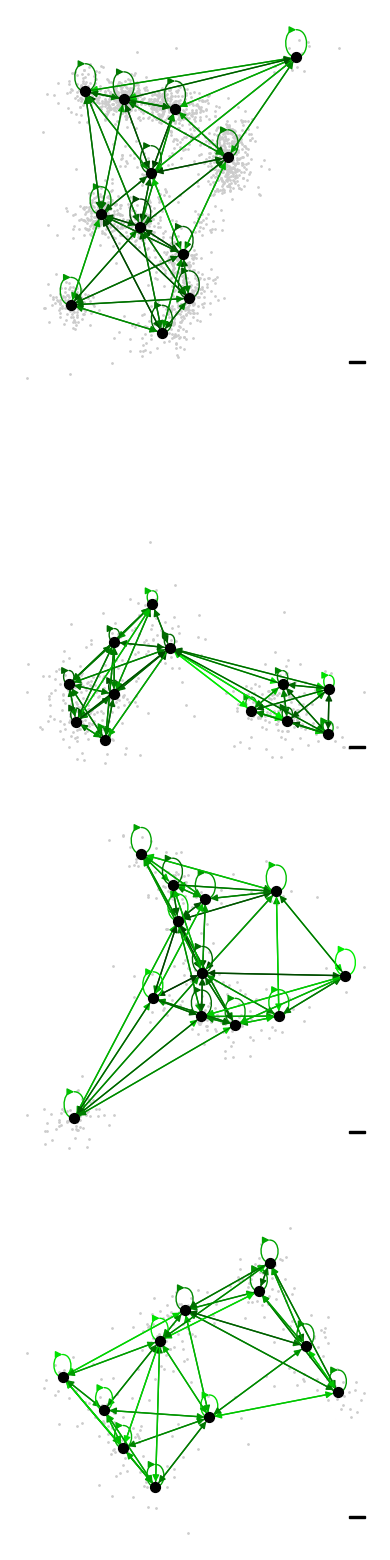

In [22]:
# visualise overlaid subgraph using matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from networkx.drawing import draw_networkx, draw, draw_networkx_nodes, draw_networkx_edges

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"

dataitems_attn = torch.load(os.path.join(project_directory, "output/attention_dataitems.pt"))
edge_imps_attn = torch.load(os.path.join(project_directory, "output/attention_edgeimps.pt"))

colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("br", colors)

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    
    file_loc = find_graph_path(project_directory, file_name, file_folder)
    # raw file
    processed_file = torch.load(file_loc)
    processed_file = processed_file.pos_dict['locs'].cpu().numpy()
    x = processed_file[:,0]
    y = processed_file[:,1]
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c='0.8')
    #ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower right', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
    # graph
    nx_g = to_networkx(dataitems_attn[idx])
    pos = dataitems_attn[idx].pos.cpu().numpy()
    edge_color = cm(edge_imps_attn[idx].cpu())
    #if 0:
    #    neg_edges = np.argwhere(edge_imps_attn[idx].cpu().numpy() == 0.0)
    #    neg_edges = np.array([e for e in nx_g.edges])[neg_edges[:,0]]
    #    neg_edges = [tuple(val) for val in neg_edges]
    #    edges = list(nx_g.edges)
    #    remove_indices = [i for i, item in enumerate(edges) if item in neg_edges]
    #    edge_color = np.delete(edge_color, remove_indices, axis=0)
    #    nx_g.remove_edges_from(neg_edges)
    if remove_self_loops:
        self_loops = list(nx.selfloop_edges(nx_g))
        edges = list(nx_g.edges)
        remove_indices = [i for i, item in enumerate(edges) if item in self_loops]
        edge_color = np.delete(edge_color, remove_indices, axis=0)
        nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
    #if 0:
    #    min = np.min(edge_color[:,1])
    #    max = np.max(edge_color[:,1])
    #    edge_color[:,1] = (edge_color[:,1] - min)/(max - min)
    draw(nx_g, pos=np.flip(pos, axis= 1), ax=ax[idx], edge_color=edge_color, node_size=50, node_color='k', connectionstyle="arc3,rad=0.0")
    # add colorbar
#sm = plt.cm.ScalarMappable(cmap=cm)
#sm._A = []
#plt.colorbar(sm, ax=ax[-1], fraction=0.01)
output_path = os.path.join(project_directory, "output", "combined" + '_attention_all_edges_s_1.svg') # _all_edges_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)

Visualise as above but picking top 10 edges

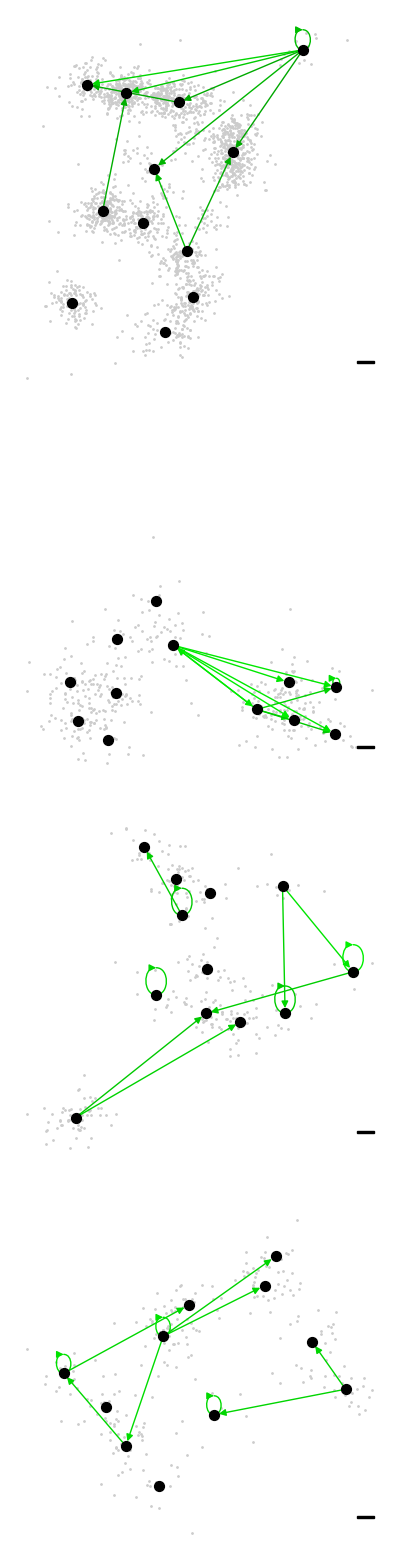

In [23]:
# visualise overlaid subgraph using matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from networkx.drawing import draw_networkx, draw, draw_networkx_nodes, draw_networkx_edges

if not final_test:
    fold = config["fold"]
    file_folder = f"processed/fold_{fold}"
else:
    file_folder = "processed"

dataitems_attn = torch.load(os.path.join(project_directory, "output/attention_dataitems.pt"))
edge_imps_attn = torch.load(os.path.join(project_directory, "output/attention_edgeimps.pt"))

colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("br", colors)

fig, ax = plt.subplots(4,1,figsize=(20,20), sharex=True, sharey=True)
for idx, file_name in enumerate(files):
    
    file_loc = find_graph_path(project_directory, file_name, file_folder)
    # raw file
    processed_file = torch.load(file_loc)
    processed_file = processed_file.pos_dict['locs'].cpu().numpy()
    x = processed_file[:,0]
    y = processed_file[:,1]
    ax[idx].set_aspect('equal', adjustable='box')
    ax[idx].scatter(y, x, s=1, c='0.8')
    #ax[idx].axis('off')
    scalebar = AnchoredSizeBar(ax[idx].transData,
                               0.1, '', 'lower right', 
                               pad=1,
                               color='k',
                               frameon=False,
                               size_vertical=0.01)

    ax[idx].add_artist(scalebar)
    # graph
    nx_g = to_networkx(dataitems_attn[idx])
    pos = dataitems_attn[idx].pos.cpu().numpy()
    edge_color = cm(edge_imps_attn[idx].cpu())

    # remove edges below top 10
    neg_edges = np.argwhere(edge_imps_attn[idx].cpu().numpy() < sorted(edge_imps_attn[idx].cpu().numpy())[-top_k])
    neg_edges = np.array([e for e in nx_g.edges])[neg_edges[:,0]]
    neg_edges = [tuple(val) for val in neg_edges]
    edges = list(nx_g.edges)
    remove_indices = [i for i, item in enumerate(edges) if item in neg_edges]
    edge_color = np.delete(edge_color, remove_indices, axis=0)

    nx_g.remove_edges_from(neg_edges)
    
    if remove_self_loops:
        self_loops = list(nx.selfloop_edges(nx_g))
        edges = list(nx_g.edges)
        remove_indices = [i for i, item in enumerate(edges) if item in self_loops]
        edge_color = np.delete(edge_color, remove_indices, axis=0)
        nx_g.remove_edges_from(nx.selfloop_edges(nx_g))
    
    #if 1:
    #    min = np.min(edge_color[:,1])
    #    max = np.max(edge_color[:,1])
    #    edge_color[:,1] = (edge_color[:,1] - min)/(max - min)
    draw(nx_g, pos=np.flip(pos, axis= 1), ax=ax[idx], edge_color=edge_color, node_size=50, node_color='k', connectionstyle="arc3,rad=0.0")
    # add colorbar
#sm = plt.cm.ScalarMappable(cmap=cm)
#sm._A = []
#plt.colorbar(sm, ax=ax[-1], fraction=0.01)
output_path = os.path.join(project_directory, "output", "combined" + '_attention_top_10_edges_s_1.svg') # _all_edges_s_1.svg') 
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0)